In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import OneHotEncoder  
from scipy.stats import skew
from sklearn.model_selection import learning_curve
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA, KernelPCA


from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB

In [2]:
# import training dataset
origin_data=pd.read_csv('train.csv')

In [3]:
def visualization(data):
    # heatmap
    corrmat = data.corr()
    plt.subplots(figsize=(12,9))
    sns.heatmap(corrmat,square=True,cmap='YlGnBu')
    
    # YearSold & SalePrice
    plt.figure(figsize=(10,5))
    sns.boxplot(x=data.YrSold, y=data.SalePrice)
    
    # OverallQual & SalePrice
    plt.figure(figsize=(10,5))
    sns.boxplot(x=data.OverallQual, y=data.SalePrice)
    
    # OverallCond & SalePrice
    plt.figure(figsize=(10,5))
    sns.boxplot(x=data.OverallCond, y=data.SalePrice)
   
    # Neighborhood & LotFrontage
    plt.figure(figsize=(10,5))
    sns.boxplot(x=data.Neighborhood, y=data.LotFrontage)
  
    # YearBuilt & SalePrice
    plt.figure(figsize=(15,8))
    sns.boxplot(x=data.YearBuilt, y=data.SalePrice)
  
    # null values
    null_data = (data.isnull().sum() / len(data)) * 100
    null_data = null_data.drop(null_data[null_data == 0].index).sort_values(ascending=False)[:10]
    plt.figure(figsize=(15, 8)) 
    plt.bar(range(len(null_data)), null_data,tick_label=null_data.index)

    # LotFrontage & LotArea
    data_sub1 = data[['LotFrontage','YearBuilt','LotArea']]
    corr_sub1 = data_sub1.corr()
    plt.subplots(figsize=(10,10))
    sns.heatmap(corr_sub1,square=True,cmap='YlGnBu')
    
    # Outliers
    plt.subplots(figsize=(10,10))
    plt.scatter(x=data.GrLivArea, y=data.SalePrice)
    plt.xlabel("GrLivArea", fontsize=13)
    plt.ylabel("SalePrice", fontsize=13)

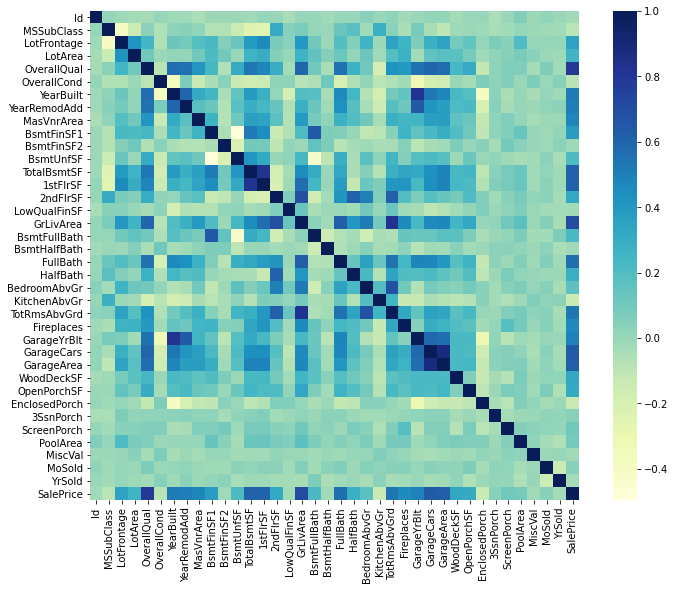

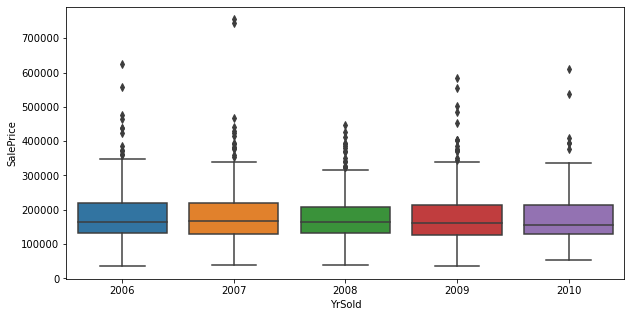

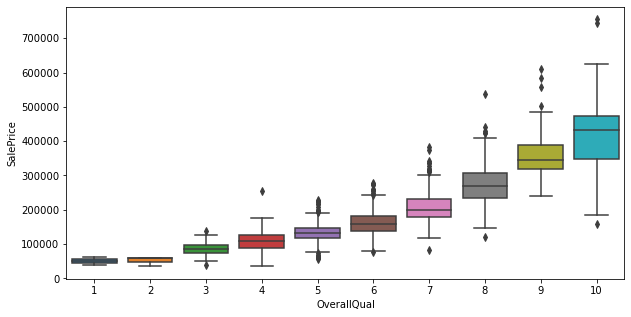

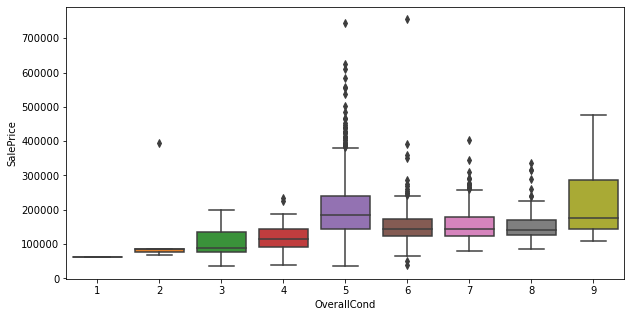

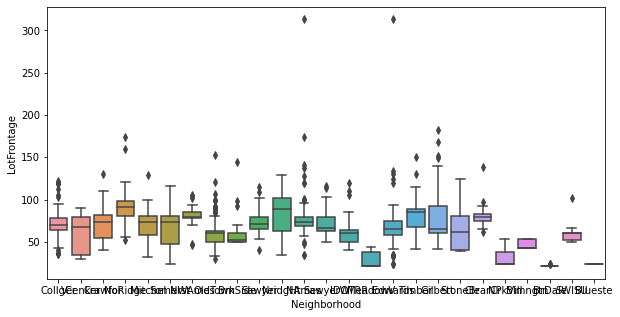

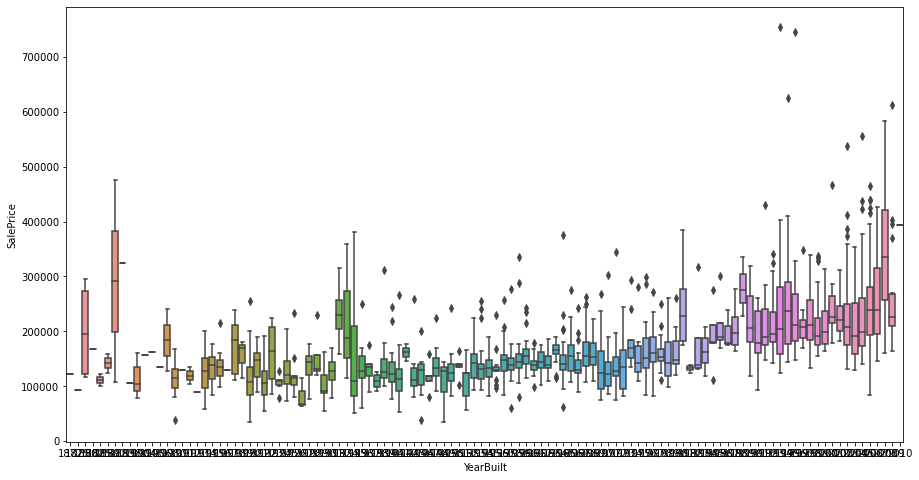

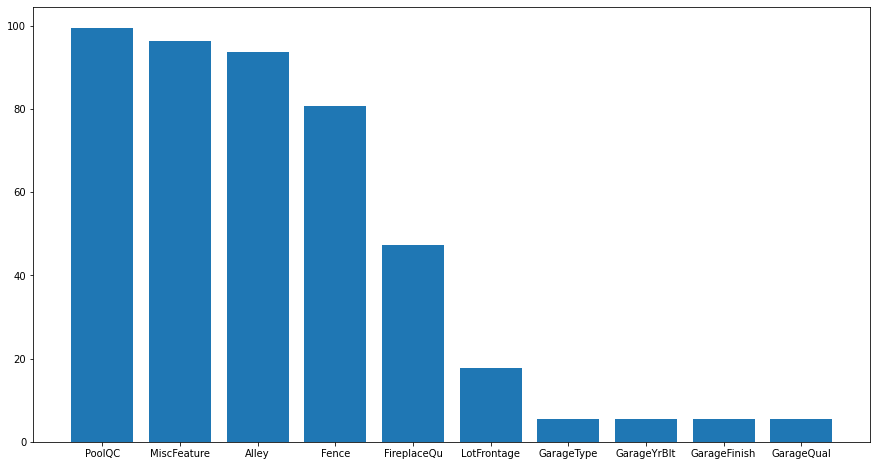

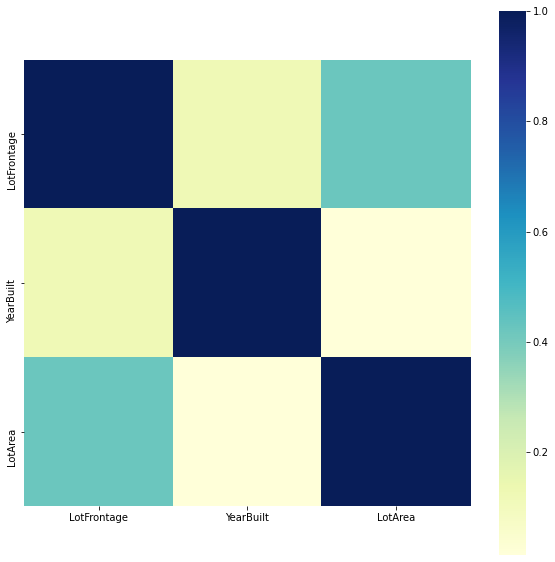

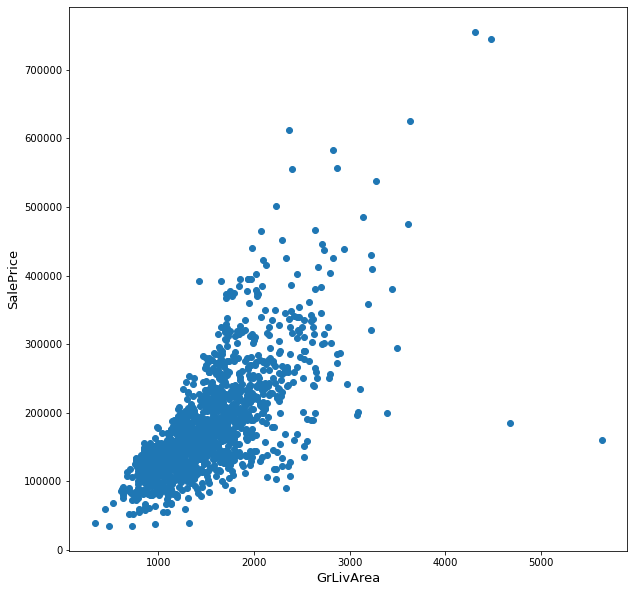

In [4]:
visualization(origin_data)

In [5]:
# fill na values
def missing_values(data):
    
    # LotFrontage
    data["LotAreaCut"] = pd.qcut(data.LotArea,10)
    data['LotFrontage']=data.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    data.drop("LotAreaCut",axis=1,inplace=True)
    
    # For numeric values, we fill zero.
    cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
    for col in cols:
        data[col].fillna(0, inplace=True)
        
     # For categorical values and with N/A as an option, we fill "none".
    cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
    for col in cols1:
        data[col].fillna("None", inplace=True)

    # For categorical values and without N/A as an option, we fill mode value.
    cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
    for col in cols2:
        data[col].fillna(data[col].mode()[0], inplace=True)
        
    return data

In [6]:
# map ordinal categorical values to numeric
def map_values(data):
    data['ExterQual'] = data.ExterQual.map({'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    data['ExterCond'] = data.ExterCond.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    data['BsmtQual'] = data.BsmtQual.map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
    data['BsmtCond'] = data.BsmtCond.map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
    data['BsmtExposure'] = data.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':4, 'Gd':5})
    data['HeatingQC'] = data.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    data['KitchenQual'] = data.KitchenQual.map({'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    data['FireplaceQu'] = data.FireplaceQu.map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
    return data

In [7]:
# handle skewed data
def handle_skewness(data):
    data_numeric=data.select_dtypes(exclude=["object"])
    skewness = data_numeric.apply(lambda x: skew(x))
    skewness_features = skewness[abs(skewness) >= 1].index   # heavily skewed
    data[skewness_features] = np.log1p(data[skewness_features])
    return data

<AxesSubplot:ylabel='Density'>

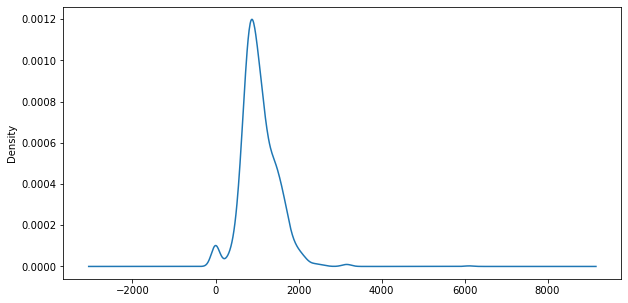

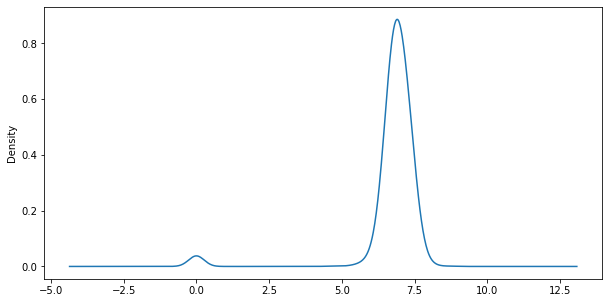

In [8]:
testData=origin_data.copy()
plt.subplots(figsize=(10,5))
testData['TotalBsmtSF'].plot(kind = 'density')
data = handle_skewness(testData)
plt.subplots(figsize=(10,5))
data['TotalBsmtSF'].plot(kind = 'density')

In [9]:
# convert nominal categorical labels to code via oneHotEncode
def encodeData(data):
    t = pd.get_dummies(data)
    return t 

In [10]:
def feature_eng1(data):
    data.drop(data[(data["GrLivArea"]>4000)&(data["SalePrice"]<300000)].index,inplace=True)
    y=data['SalePrice']
    data.drop(["SalePrice"],axis=1,inplace=True)
    data.drop(["Id"],axis=1,inplace=True)
    data=missing_values(data)
    data=map_values(data)
    data=handle_skewness(data)
    data=encodeData(data)
    
    
    scaler = preprocessing.StandardScaler()

    x = scaler.fit(data).transform(data)
    
    lasso=Lasso(alpha=0.001)
    lasso.fit(x,y)
    selectFeatures = pd.DataFrame({"importance":lasso.coef_}, index=data.columns)
    importance = selectFeatures[selectFeatures["importance"]!=0].apply(lambda x: abs(x)).sort_values("importance",ascending=True)
    most=importance.tail(20)
    most.plot(kind="barh",figsize=(15,10))
    plt.xticks(rotation=90)
    plt.show()
    
    return data,x,y

/Users/aranne/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264968512185.809, tolerance: 920745877.805445
  model = cd_fast.enet_coordinate_descent(


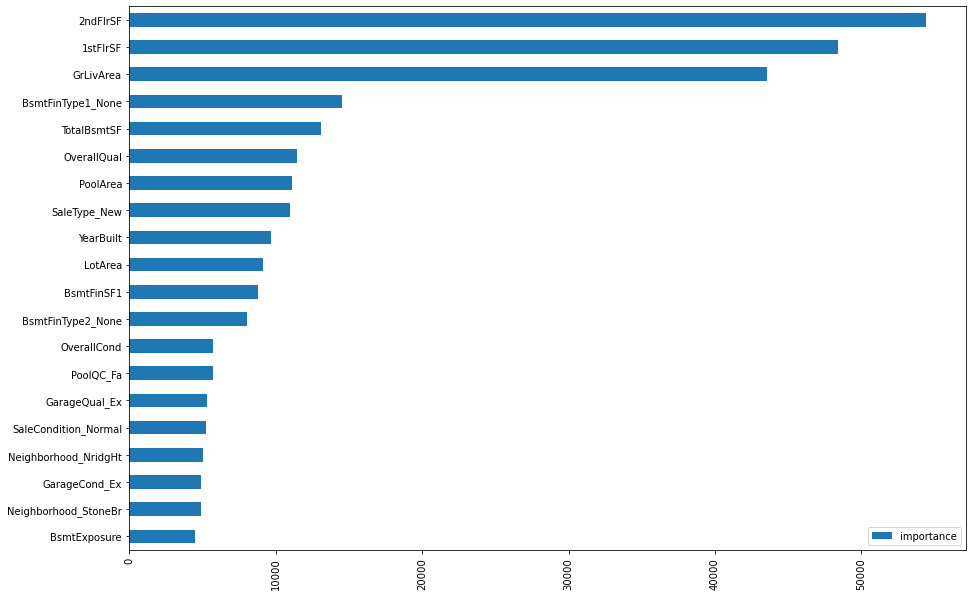

(1458, 367)


In [11]:
testData=origin_data.copy()
testData,x,y=feature_eng1(testData)
print(testData.shape)

In [12]:
def feature_creation(data):
    data["TotalHouse"] = data["TotalBsmtSF"] + data["1stFlrSF"] + data["2ndFlrSF"]   
    data["TotalArea"] = data["TotalBsmtSF"] + data["1stFlrSF"] + data["2ndFlrSF"] + data["GarageArea"]+data["PoolArea"]
    
    data['TotalHouse_OverallQual']=data['TotalHouse']*data['OverallQual']
    data['TotalArea_OverallQual']=data['TotalArea']*data['OverallQual']
    data['GrLivArea_OverallQual']=data['GrLivArea']*data['OverallQual']
    data['YearBuilt_OverallQual']=data['YearBuilt']*data['OverallQual']
    data['OverallCond_OverallQual']=data['OverallCond']*data['OverallQual']
    
    data['TotalHouse_LotArea']=data['TotalHouse']*data['LotArea']
    data['GrLivArea_LotArea']=data['GrLivArea']*data['LotArea']
    
    data['GarageCars_GarageArea']=data['GarageCars']*data['GarageArea']
    
    for col in data:
        if col.startswith('Neighborhood'):
            data[col+'_OverallQual']=data[col]*data['OverallQual']
            data[col+'_TotalHouse']=data[col]*data['TotalHouse']
            data[col+'_TotalArea']=data[col]*data['TotalArea']
    return data

In [13]:
# Add features based from feature_eng1 result
def feature_eng2(data):
    data.drop(data[(data["GrLivArea"]>4000)&(data["SalePrice"]<300000)].index,inplace=True)

    y=data['SalePrice']
    data.drop(["SalePrice"],axis=1,inplace=True)
    data.drop(["Id"],axis=1,inplace=True)
    data=missing_values(data)
    data=map_values(data)
    data=handle_skewness(data)
    data=encodeData(data)
    
    data=feature_creation(data)
    
    scaler = preprocessing.StandardScaler()

    x = scaler.fit(data).transform(data)
    
    lasso=Lasso(alpha=0.001)
    lasso.fit(x,y)
    selectFeatures = pd.DataFrame({"importance":lasso.coef_}, index=data.columns)
    importance = selectFeatures[selectFeatures["importance"]!=0].apply(lambda x: abs(x)).sort_values("importance",ascending=True)
    most=importance.tail(20)
    most.plot(kind="barh",figsize=(15,10))
    plt.xticks(rotation=90)
    plt.show()
    return data,x,y

/Users/aranne/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176619659448.4013, tolerance: 920745877.805445
  model = cd_fast.enet_coordinate_descent(


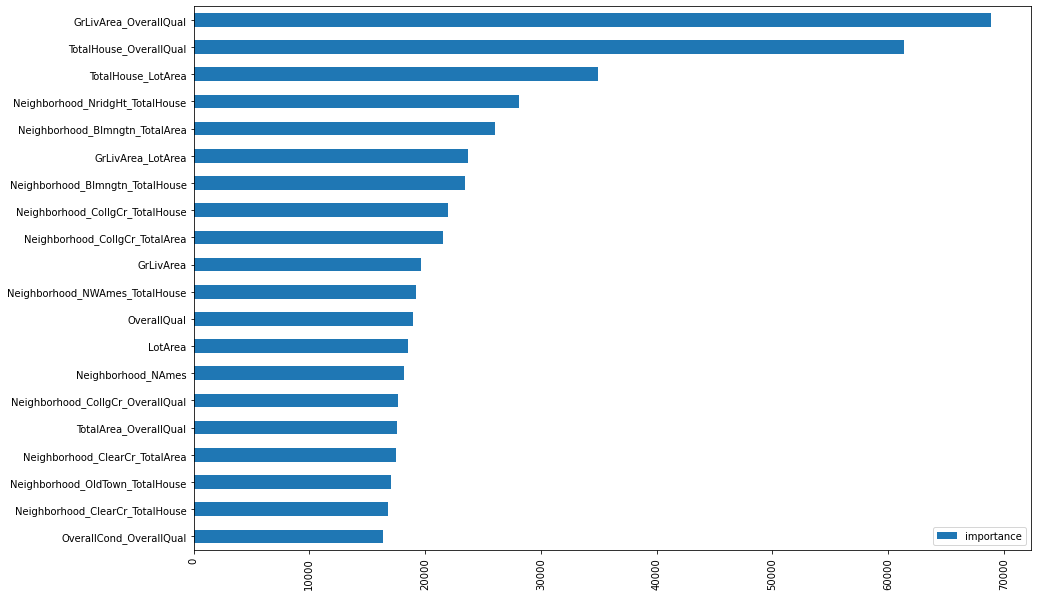

(1458, 452)


In [14]:
testData=origin_data.copy()
testData,x,y=feature_eng2(testData)
print(testData.shape)

In [15]:
# PCA based on feature_eng2
def feature_eng3(data):
    data.drop(data[(data["GrLivArea"]>4000)&(data["SalePrice"]<300000)].index,inplace=True)
    y=data['SalePrice']
    data.drop(["SalePrice"],axis=1,inplace=True)
    data.drop(["Id"],axis=1,inplace=True)

    data=missing_values(data)
    data=map_values(data)
    data=handle_skewness(data)
    data=encodeData(data)
    data=feature_creation(data)
    
    scaler = preprocessing.StandardScaler()

    x = scaler.fit(data).transform(data)

    pca = PCA(n_components=200)
    x=pca.fit_transform(x)
    
    selectFeatures = pd.DataFrame({'importance':pca.explained_variance_})
    importance = selectFeatures.sort_values("importance",ascending=True)
    most = importance.tail(20)
    most.plot(kind="barh",figsize=(15,10))
    plt.xticks(rotation=90)
    plt.show()
    return data,x,y

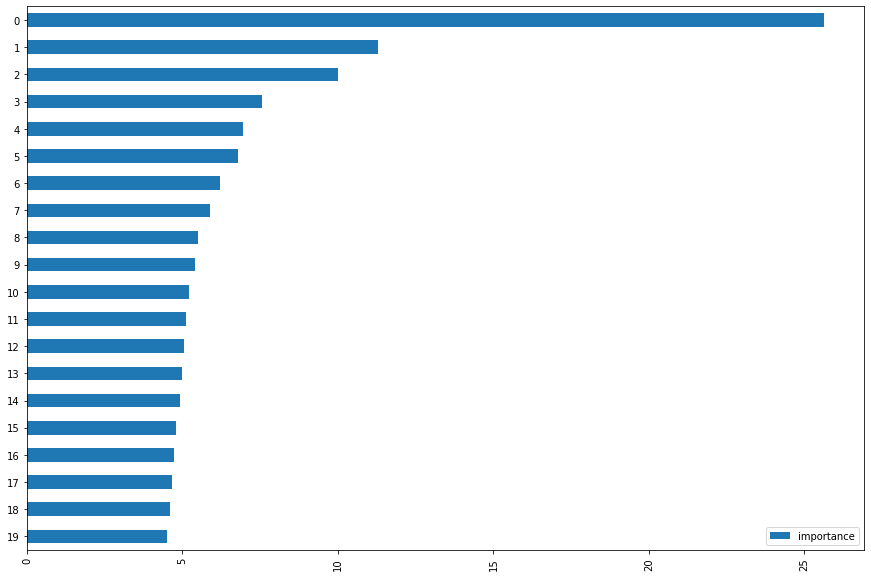

(1458, 452)


In [16]:
testData=origin_data.copy()
testData,x,y=feature_eng3(testData)
print(testData.shape)

In [17]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 522)
def rmse_cv(model, X, y):      
    return np.sqrt(-cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv = kf)).mean()

In [18]:
def test():
    data1=origin_data.copy()
    data2=origin_data.copy()
    data3=origin_data.copy()
    
    data1,x1,y1=feature_eng1(data1)
    data2,x2,y2=feature_eng2(data2)
    data3,x3,y3=feature_eng3(data3)
    
    rmse1_lr=rmse_cv(LinearRegression(), x1, y1)
    rmse2_lr=rmse_cv(LinearRegression(), x2, y2)
    rmse3_lr=rmse_cv(LinearRegression(), x3, y3)
    plt.bar(range(3), [rmse1_lr,rmse2_lr,rmse3_lr],tick_label=["original features","with feature creation","with PCA selection"])
    print(rmse1_lr)
    print(rmse2_lr)
    print(rmse3_lr)

/Users/aranne/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264968512185.809, tolerance: 920745877.805445
  model = cd_fast.enet_coordinate_descent(


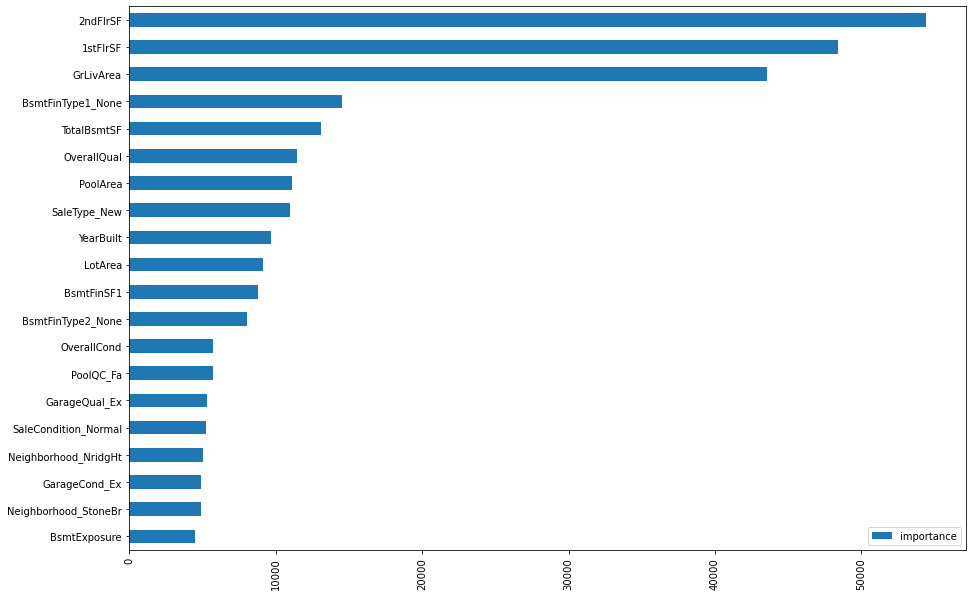

/Users/aranne/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176619659448.4013, tolerance: 920745877.805445
  model = cd_fast.enet_coordinate_descent(


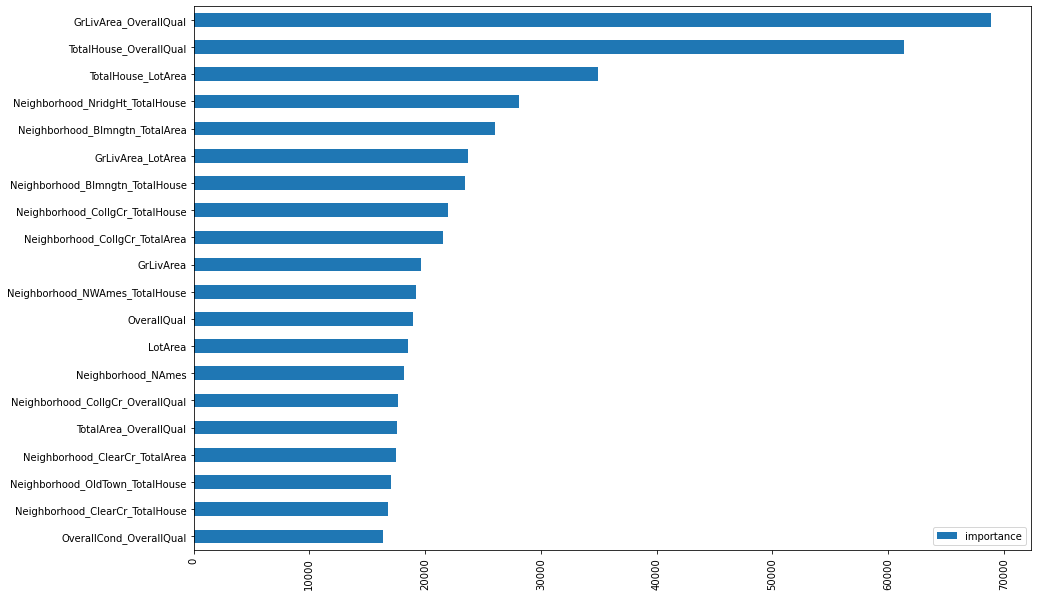

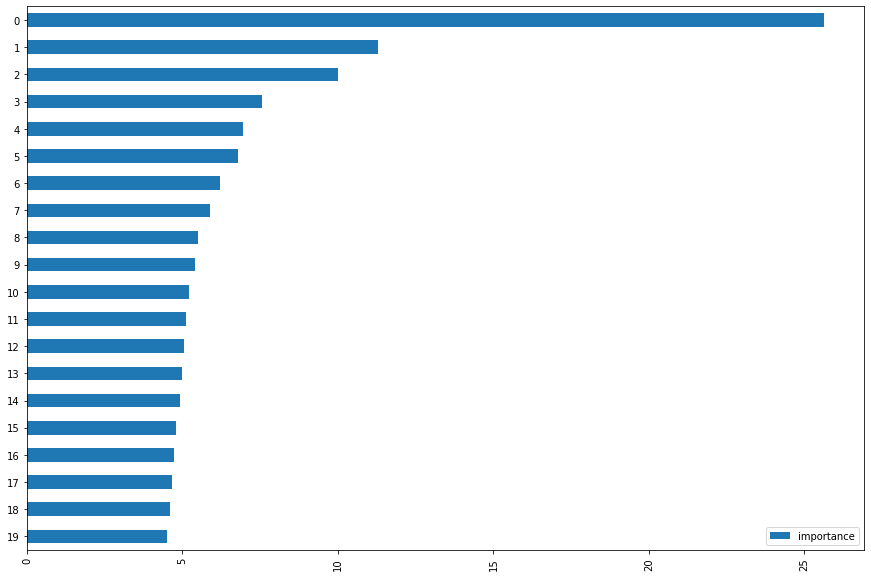

3.783715790357205e+17
1.3546552681957962e+16
31808.345408902365


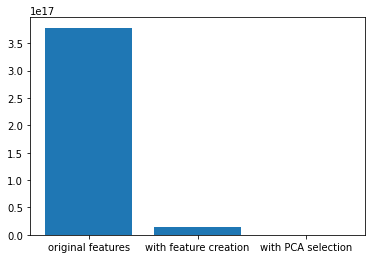

In [19]:
test()

In [20]:
def grid_Lasso(x, y):
    a=[0,1,0.1]
    hyper={'alpha':a}
    grid_search = GridSearchCV(Lasso(), param_grid=hyper,verbose=True,cv=kf,n_jobs=4)
    grid_search.fit(x,y)
    clf=grid_search.best_estimator_
    return clf

In [21]:
def grid_RF(x,y):
    n_estimators=[10,30,60]
    hyper={'n_estimators':n_estimators}
    grid_search = GridSearchCV(RandomForestClassifier(random_state=522),param_grid=hyper,verbose=True,cv=kf,n_jobs=4)
    grid_search.fit(x,y)
    clf=grid_search.best_estimator_
    return clf

In [22]:
def grid_SVC(x,y):
    C=[0.02,0.03,0.05]
    gamma=[0.001,0.0012,0.0008,0.002]
    kernel=['linear']
    hyper={'kernel':kernel,'C':C,'gamma':gamma}
    grid_search = GridSearchCV(SVC(), param_grid=hyper, verbose=True)
    grid_search.fit(x,y)
    return grid_search.best_estimator_

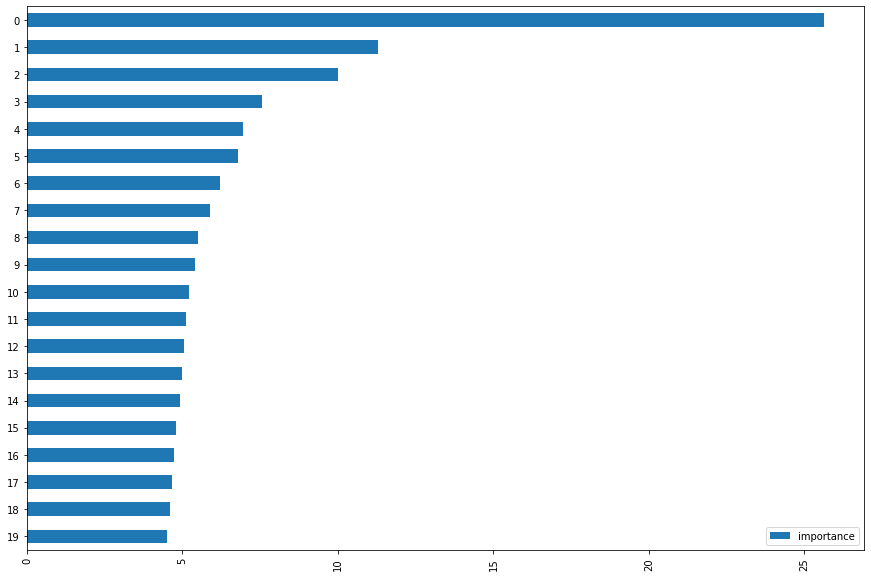

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    1.7s finished
/Users/aranne/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9210037466.495983, tolerance: 243136397.46938887
  model = cd_fast.enet_coordinate_descent(
/Users/aranne/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23584852280.033638, tolerance: 211165081.88714972
  model = cd_fast.enet_coordinate_descent(
/Users/aranne/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2567211234

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   31.1s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/aranne/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.0min finished


<BarContainer object of 4 artists>

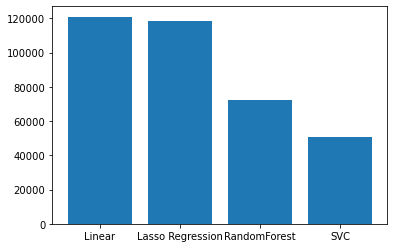

In [24]:
data=origin_data.copy()
data,x,y=feature_eng3(data)
x,x_test, y, y_test =train_test_split(x,y,test_size=0.3, random_state=522)
lr=LinearRegression()
lr.fit(x,y)
lr_rmse=rmse_cv(lr, x_test, y_test)
ls=grid_Lasso(x,y)
ls_rmse=rmse_cv(ls,x_test,y_test)
rf=grid_RF(x,y)
rf_rmse=rmse_cv(rf,x_test,y_test)
svc=grid_SVC(x,y)
svc_rmse=rmse_cv(svc,x_test,y_test)

plt.bar(range(4), [lr_rmse,ls_rmse,rf_rmse,svc_rmse],tick_label=["Linear","Lasso Regression","RandomForest","SVC"])